In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rosbag
import pymap3d as pm
import numba as nb

from scipy.signal import savgol_filter
%matplotlib inline

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

@nb.njit()
def to_euler(x, y, z, w):
    """Dari Coursera: Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return np.array([roll, pitch, yaw])
# Compile the to_euler
_ = to_euler(1.5352300785980803e-15, -1.3393747145983517e-15, -0.7692164172827881, 0.638988343698562)

# Import Data

In [3]:
ls

cek_data.ipynb
ukf_long_log_0,075_2020-08-19-14-32-05.bag
ukf_long_log_0,1_2020-08-19-14-23-47.bag
ukf_long_log_0,125_2020-08-19-14-30-02.bag
ukf_long_log_0,15_2020-08-19-14-25-24.bag
ukf_long_log_0,2_2020-08-19-14-26-48.bag
ukf_long_log_0,25_2020-08-19-14-28-54.bag
ukf_long_log_0,3_2020-08-19-14-27-55.bag
ukf_long_log_0,4_2020-08-19-14-34-09.bag


In [4]:
bag = rosbag.Bag('ukf_long_log_0,15_2020-08-19-14-25-24.bag')
bag.get_type_and_topic_info()

TypesAndTopicsTuple(msg_types={'diagnostic_msgs/DiagnosticArray': '60810da900de1dd6ddd437c3503511da', 'dynamic_reconfigure/Config': '958f16a05573709014982821e6822580', 'dynamic_reconfigure/ConfigDescription': '757ce9d44ba8ddd801bb30bc456f946f', 'geometry_msgs/TwistStamped': '98d34b0043a2093cf9d9345ab6eef12e', 'nav_msgs/Odometry': 'cd5e73d190d741a2f92e81eda573aca7', 'pkg_ta/Control': 'f3ff5e621674977340f826fa8303fddf', 'pkg_ta/LogArduino': '794f6f831f1064c1b29b65087ebb232f', 'rosgraph_msgs/Log': 'acffd30cd6b6de30f120938c17c593fb', 'sensor_msgs/Imu': '6a62c6daae103f4ff57a132d6f95cec2', 'sensor_msgs/NavSatFix': '2d3a8cd499b9b4a0249fb98fd05cfa48', 'sensor_msgs/TimeReference': 'fded64a0265108ba86c3d38fb11c0c16', 'tf2_msgs/TFMessage': '94810edda583a504dfda3829e70d7eec'}, topics={'/control_signal': TopicTuple(msg_type='pkg_ta/Control', message_count=478, connections=1, frequency=20.002212769204355), '/diagnostics': TopicTuple(msg_type='diagnostic_msgs/DiagnosticArray', message_count=74, conne

## Filtered UTM

In [5]:
u_t = []
u_x = []
u_y = []
u_v = []
for topic, msg, _ in bag.read_messages(topics=['/odometry/utm_filtered']):
    u_t.append(msg.header.stamp.to_sec())
    pos = msg.pose.pose.position
    u_x.append(pos.x)
    u_y.append(pos.y)
    v = msg.twist.twist.linear
    u_v.append(np.sqrt(v.x**2 + v.y**2)) # Ini kayaknya emang 0 terus
u_t = np.array(u_t)
u_x = np.array(u_x)
u_y = np.array(u_y)
u_v = np.array(u_v)

## Filtered Map

In [6]:
f_t = []
f_x = []
f_y = []
f_yaw = []
f_v = []
for topic, msg, _ in bag.read_messages(topics=['/odometry/filtered_map']):
    f_t.append(msg.header.stamp.to_sec())
    pos = msg.pose.pose.position
    f_x.append(pos.x)
    f_y.append(pos.y)
    q = msg.pose.pose.orientation
    euler = to_euler(q.x, q.y, q.z, q.w)
    f_yaw.append(euler[-1])
    v = msg.twist.twist.linear
    f_v.append(np.sqrt(v.x**2 + v.y**2))
f_t = np.array(f_t)
f_x = np.array(f_x)
f_y = np.array(f_y)
f_yaw = np.array(f_yaw)
f_v = np.array(f_v)

## Yaw IMU

In [7]:
imu_t = []
imu_yaw = []
for topic, msg, _ in bag.read_messages(topics=['/imu']):
    imu_t.append(msg.header.stamp.to_sec())
    q = msg.orientation
    euler = to_euler(q.x, q.y, q.z, q.w)
    imu_yaw.append(euler[-1])
imu_t = np.array(imu_t)
imu_yaw = np.array(imu_yaw)

## Data Arduino

In [8]:
a_t = []
a_steering_setpoint = []
a_steering_angle = []
a_throttle_voltage = []
for topic, msg, _ in bag.read_messages(topics=['/logging_arduino']):
    a_t.append(msg.header.stamp.to_sec())
    a_steering_setpoint .append(msg.steering_setpoint )
    a_steering_angle.append(msg.steering_angle)
    a_throttle_voltage.append(msg.throttle_voltage)
a_t = np.array(a_t)
a_steering_setpoint = np.array(a_steering_setpoint)
a_steering_angle = np.array(a_steering_angle)
a_throttle_voltage = np.array(a_throttle_voltage)

## GPS

In [9]:
lat0, lon0, h0 = -6.8712, 107.5738, 768
gps_t = []
gps_pos = []
gps_cov = []
for topic, msg, _ in bag.read_messages(topics=['/fix']):
    gps_t.append(msg.header.stamp.to_sec())
    gps_pos.append(pm.geodetic2enu(msg.latitude, msg.longitude, msg.altitude, lat0, lon0, h0))
    gps_cov.append(msg.position_covariance)
gps_t = np.array(gps_t)
gps_pos = np.array(gps_pos)
gps_cov = np.array(gps_cov).reshape(-1,3,3)

In [10]:
gps_n = np.array(gps_pos[:,:2]) - gps_pos[0,:2]

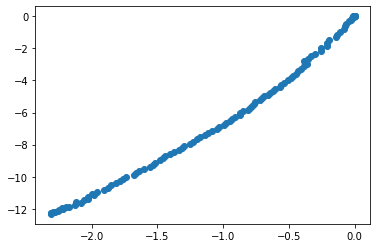

In [11]:
plt.scatter(gps_n[:,0], gps_n[:,1])

In [12]:
gps_vx = np.gradient(gps_pos[1:,0] - gps_pos[:-1,0], gps_t[:-1])
gps_vy = np.gradient(gps_pos[1:,1] - gps_pos[:-1,1], gps_t[:-1])
gps_v = np.sqrt(gps_vx**2 + gps_vy**2)

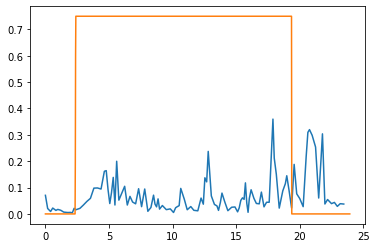

In [13]:
plt.plot(gps_t[:-1]-gps_t[0], gps_v, label='gps velocity')
plt.plot(a_t - a_t[0], a_throttle_voltage / 4096 * 5)

# Analisis dan PLOT

## Kecepatan

In [14]:
f_v.shape

(757,)

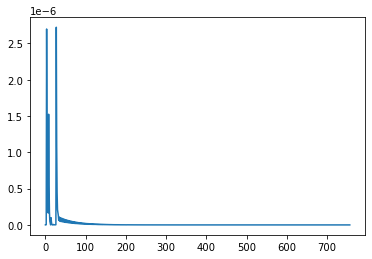

In [15]:
plt.plot(f_v)

## Posisi

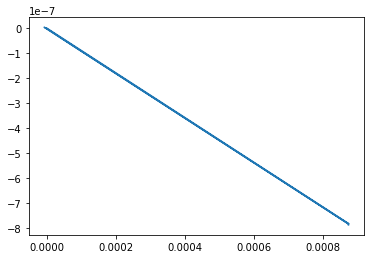

In [16]:
# Jadiin 0,0 supaya enak diliat aja
u_xn = u_x - u_x[0]
u_yn = u_y - u_y[0]
plt.plot(u_xn, u_yn)

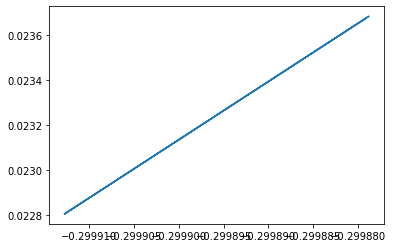

In [17]:
plt.plot(f_x, f_y)

## Yaw

In [18]:
u_x.shape

(552,)

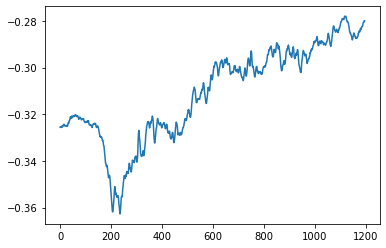

In [19]:
plt.plot(imu_yaw)

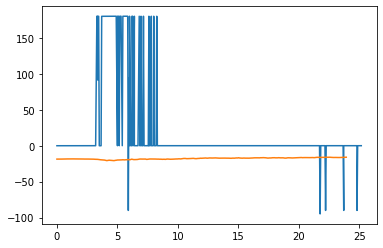

In [20]:
# Ada Offset dan Noisy
# Noise di awal itu karena kita liat yaw utm_filtered dari delta, jadi pas mundur, jadinya aneh. Karena awalnya aku DIAM dulu
u_x_savgol = savgol_filter(u_x, 151, 3)
u_y_savgol = savgol_filter(u_y, 151, 3)
utm_yaw = np.arctan2(u_y_savgol[1:]-u_y_savgol[:-1], u_x_savgol[1:] - u_x_savgol[:-1])

#u_x_diff_savgol = savgol_filter(u_x[1:]-u_x[:-1], 151, 3)
#u_y_diff_savgol = savgol_filter(u_y[1:]-u_y[:-1], 151, 3)
#utm_yaw = np.arctan2(u_y_diff_savgol, u_x_diff_savgol)

plt.plot(u_t[:-1] - u_t[0], utm_yaw*180/np.pi)
plt.plot(imu_t - imu_t[0], imu_yaw*180/np.pi)

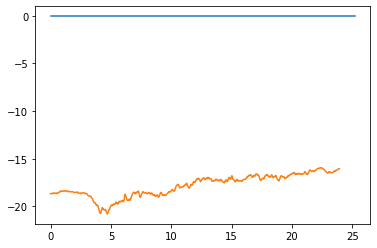

In [21]:
u_xn = u_x - u_x[0]
u_yn = u_y - u_y[0]

# Karena lintasan relatif lurus, yaw sesungguhnya bisa didekati dengan persamaan linear
gradient = np.arctan2(u_yn[-1]-u_yn[0], u_xn[-1]-u_xn[0])
gradient = np.array([gradient for i in range(u_xn.shape[0])])
plt.plot(u_t - u_t[0], gradient*180/np.pi)
plt.plot(imu_t - imu_t[0], (imu_yaw)*180/np.pi)

## Curvature

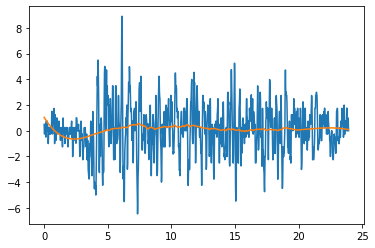

In [22]:
imu_tn = imu_t - imu_t[0]
curv = np.gradient(imu_yaw, imu_tn)
curv_savgol = savgol_filter(curv, 401, 3)
plt.plot(imu_tn, np.arctan(curv)*180/np.pi)
plt.plot(imu_tn, np.arctan(curv_savgol)*180/np.pi)